# Лабораторная работа №1. 

Данная лабораторная работа состоит из нескольких блоков. В каждом блоке вам предлагается произвести некоторые манипуляции с данными и сделать некоторые выводы.
* Задавать вопросы можно и нужно.
* Списывать не нужно. Работы, которые были списаны обнуляются.
* Блоки выполняются последовательно и оцениваются отдельно.

##  Part 2. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

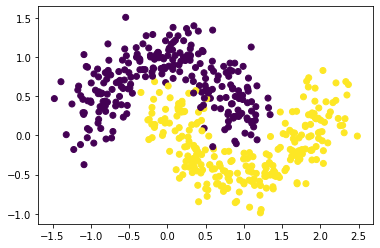

In [48]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)
points_train, points_test, labels_train, labels_test = train_test_split(moons_points, moons_labels, 
                                                                        random_state = 0, shuffle = True)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

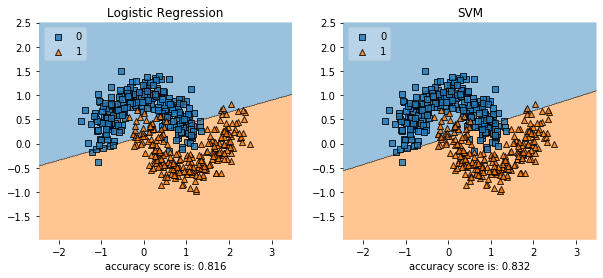

In [49]:
lr = LogisticRegression(penalty = 'l1', max_iter = 10000, solver = 'saga', n_jobs = -1) # add some params
lr.fit(points_train, labels_train)
svm = SVC(C = 0.5, kernel = 'linear') # here too
svm.fit(points_train, labels_train)

def plot_decisions(dataset = [[moons_points, moons_labels]], test_data = [[points_test, labels_test]], \
                   score = accuracy_score, clfs = [lr, svm], labels = ['Logistic Regression', 'SVM']):
    
    if (len(labels) != 1):
        value, width = 1.5, 0.75
        fig, axs = plt.subplots(nrows=1, ncols=len(labels), figsize=(10, 4))
        indexes = [0]*len(labels) if len(dataset) == 1 else range(len(dataset))
        for clf, lab, grd, index in zip(clfs, labels, range(len(labels)), indexes):

            filler_feature_values_ = {} if len(dataset[index][0][0]) == 2 else {i:value for i in range(2, len(dataset[index][0][0]))}
            filler_feature_ranges_ = {} if len(dataset[index][0][0]) == 2 else {i:width for i in range(2, len(dataset[index][0][0]))}
            prediction = clf.predict(test_data[index][0])
            axs[grd] = plot_decision_regions(X = dataset[index][0], y = dataset[index][1], \
                                             clf = clf, ax=axs[grd], legend = 2, feature_index=[0,1], 
                                             filler_feature_values=filler_feature_values_,
                                             filler_feature_ranges=filler_feature_ranges_)
            axs[grd].title.set_text(lab)
            axs[grd].set_xlabel('accuracy score is: ' + str(accuracy_score(prediction, test_data[index][1])))
    else:
        fig, axs = plt.subplots()
        axs = plot_decision_regions(X = dataset[0][0], y = dataset[0][1], clf = clfs[0], ax = axs, legend = 2)
        axs.title.set_text(labels[0])
        axs.set_xlabel('accuracy score is: ' + str(accuracy_score(clfs[0].predict(test_data[0][0]), 
                                                                       test_data[0][1])))
    plt.show()

plot_decisions()

#### Results description.
Because of linear kernels the same in classifirers, models roughly have given the same results. I could tune parametrs in scikit-learn models, but you have written me to cannot do it. You can see calculated accuracy score metric in the right bottom of figure.

## 1.2 Kernel tirck

![keep-calm](imgs/keep-calm.jpg)

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

Best params for poly kernel is:  {'C': 9.307022574766952, 'coef0': 2.6842105263157894, 'degree': 3}
Best params for rbf kernel is:  {'C': 14.726596907936274, 'coef0': -50.0}
Best params for sigmoid kernel is:  {'C': 2980.9579870417283, 'coef0': -5.368421052631582}



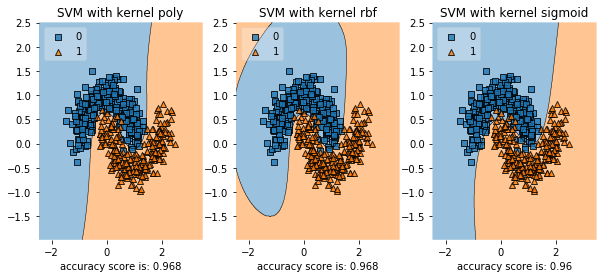

In [15]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook

clfs_, labels_ = [], []
for kernel_ in tqdm_notebook(['poly', 'rbf', 'sigmoid']):
    svm = SVC(C = 0.5, kernel = kernel_, gamma = 'scale')
    if kernel_ == 'poly':
        param_grid = {'C': np.exp(np.linspace(-3, 3, 40)), 'degree': range(2, 4), \
                      'coef0': np.linspace(-3, 3, 20)}
    else:
        param_grid = {'C': np.exp(np.linspace(-3, 8, 30)), 'coef0': np.linspace(-50, 3, 20)}
    search_params = GridSearchCV(svm, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1, iid = False)
    search_params.fit(points_train, labels_train)
    print('Best params for ' + kernel_ + ' kernel is: ', search_params.best_params_)
    labels_.append('SVM with kernel ' + kernel_)
    clfs_.append(search_params)
    
plot_decisions(clfs = clfs_, labels = labels_)

#### Results description.
* Classification quality has increased of course becouse of applying nonlinear kernels like sigmoid, poly or rbf. By the way, kernels named rbf and sigmoid retrain very quickly, you can see this negative effect on best params.
* Decision border have changed by smooth border, the best result we can see on SVM with kernel 'poly'. Other kernels have acquired borders incomprehensible to me.
* The 'degree' parametr only play role when is being used 'poly' kernel. I think that the best 'degree' is 3 becouse of f(x) = x^3 function view.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitic Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

Best params for 1 degree is:  {'C': 0.049787068367863944, 'solver': 'saga'}
Best params for 2 degree is:  {'C': 10.680514992399115, 'solver': 'saga'}
Best params for 3 degree is:  {'C': 7.788369872097396, 'solver': 'liblinear'}
Best params for 4 degree is:  {'C': 7.788369872097396, 'solver': 'liblinear'}



/Users/ilyabasharov/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


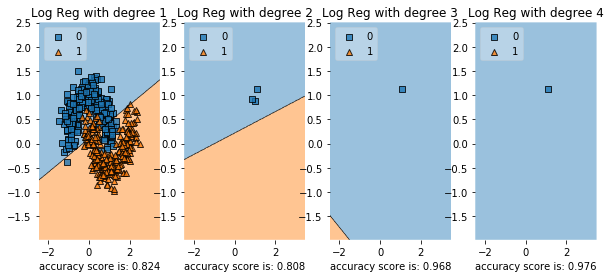

In [16]:
from sklearn.preprocessing import PolynomialFeatures

clfs_, labels_, dataset_, test_data_ = [], [], [], []

for degree in tqdm_notebook(range(1, 5)):
    lr = LogisticRegression(penalty = 'l1', max_iter = 10000, solver = 'saga')
    
    param_grid = {'C': np.exp(np.linspace(-3, 3, 20)), 'solver': ['saga', 'liblinear']}
    search_params = GridSearchCV(lr, param_grid, scoring = 'accuracy', n_jobs = -1, cv = 5, iid = False)
    search_params.fit(PolynomialFeatures(degree, include_bias=False).fit_transform(points_train),\
                      labels_train)
    
    labels_.append('Log Reg with degree ' + str(degree))
    clfs_.append(search_params)
    dataset_.append([PolynomialFeatures(degree, include_bias=False).fit_transform(moons_points),\
                     moons_labels])
    test_data_.append([PolynomialFeatures(degree, include_bias=False).fit_transform(points_test),\
                       labels_test])
    print('Best params for ' + str(degree) + ' degree is: ', search_params.best_params_)

plot_decisions(dataset = dataset_, test_data = test_data_, clfs = clfs_, labels = labels_)

#### Results description.
* As u can see we have achieved great accuracy score compared with SVM with kernels. I have been using and comparing Logistic Regression with degrees {1, 2, 3, 4}, and the best degree is 4. You cant see useful information on figures with degree 2, 3, 4 becouse decision border was calculated by all features, and i plot border just using two first features.

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

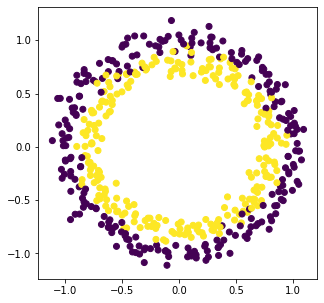

In [17]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

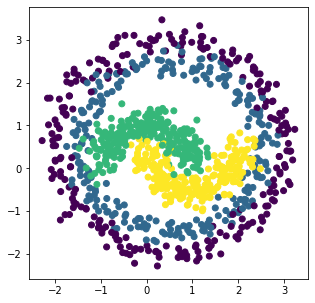

In [18]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

### For first problem with circles point

Best params for rbf kernel is:  {'C': 1.8073049083342154, 'coef0': -500.0}


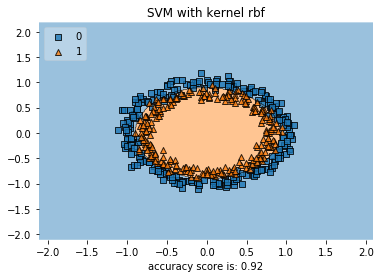

In [41]:
points_train, points_test, labels_train, labels_test = train_test_split(circles_points, circles_labels, 
                                                                        random_state = 0, shuffle = True)

svm = SVC(kernel = 'rbf', gamma = 'scale')
param_grid = {'C': np.exp(np.linspace(-3, 8, 50)), 'coef0': np.linspace(-500, 10, 200)}
search_params = GridSearchCV(svm, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1, iid = False)
search_params.fit(points_train, labels_train)
print('Best params for ' + 'rbf' + ' kernel is: ', search_params.best_params_)
        
plot_decisions(dataset = [[circles_points, circles_labels]], test_data = [[points_test, labels_test]],
               clfs = [search_params], labels = ['SVM with kernel rbf'])

### For second problem with four-classes classification

Best params for poly kernel is:  {'C': 5.866339056828965, 'coef0': 0.4736842105263155, 'degree': 4}
Best params for rbf kernel is:  {'C': 10.077899193573737, 'coef0': -50.0}
Best params for sigmoid kernel is:  {'C': 2980.9579870417283, 'coef0': -5.368421052631582}



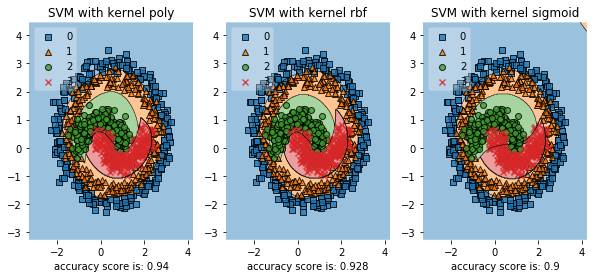

In [42]:
points_train, points_test, labels_train, labels_test = train_test_split(points, labels, 
                                                                        random_state = 0, shuffle = True)

clfs_, labels_ = [], []
for kernel_ in tqdm_notebook(['poly', 'rbf', 'sigmoid']):
    svm = SVC(kernel = kernel_, gamma = 'scale')
    if kernel_ == 'poly':
        param_grid = {'C': np.exp(np.linspace(-3, 3, 40)), 'degree': range(2, 7), \
                      'coef0': np.linspace(-3, 3, 20)}
    else:
        param_grid = {'C': np.exp(np.linspace(-3, 8, 30)), 'coef0': np.linspace(-50, 3, 20)}
    search_params = GridSearchCV(svm, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1, iid = False)
    search_params.fit(points_train, labels_train)
    print('Best params for ' + kernel_ + ' kernel is: ', search_params.best_params_)
    labels_.append('SVM with kernel ' + kernel_)
    clfs_.append(search_params)
    
plot_decisions(dataset = [[points, labels]], test_data = [[points_test, labels_test]],
               clfs = clfs_, labels = labels_)

Best params for 1 degree is:  {'C': 0.049787068367863944, 'solver': 'liblinear'}
Best params for 2 degree is:  {'C': 0.8539396656235351, 'solver': 'saga'}
Best params for 3 degree is:  {'C': 10.680514992399115, 'solver': 'saga'}
Best params for 4 degree is:  {'C': 2.202237049052355, 'solver': 'liblinear'}


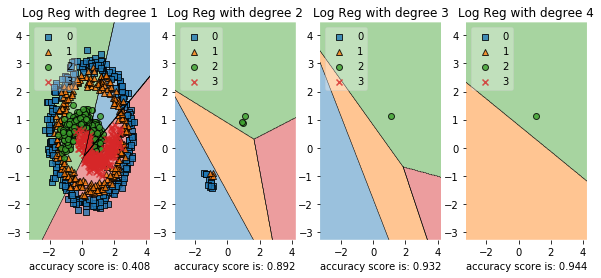

In [46]:
clfs_, labels_, dataset_, test_data_ = [], [], [], []

for degree in tqdm_notebook(range(1, 5)):
    lr = LogisticRegression(penalty = 'l1', max_iter = 100000, solver = 'saga', multi_class = 'auto')
    
    param_grid = {'C': np.exp(np.linspace(-3, 3, 20)), 'solver': ['saga', 'liblinear']}
    search_params = GridSearchCV(lr, param_grid, scoring = 'accuracy', n_jobs = -1, cv = 5, iid = False)
    search_params.fit(PolynomialFeatures(degree, include_bias=False).fit_transform(points_train),\
                      labels_train)
    
    labels_.append('Log Reg with degree ' + str(degree))
    clfs_.append(search_params)
    dataset_.append([PolynomialFeatures(degree, include_bias=False).fit_transform(points),\
                     labels])
    test_data_.append([PolynomialFeatures(degree, include_bias=False).fit_transform(points_test),\
                       labels_test])
    print('Best params for ' + str(degree) + ' degree is: ', search_params.best_params_)

plot_decisions(dataset = dataset_, test_data = test_data_, clfs = clfs_, labels = labels_)

### Sum up.
The best accuracy score showed Logistic Regression model with Polynomial Features (degree 4).
The second place in leaderboard took a place the SVM with poly kernel model.